## **Linear Regression from Scratch Using Direct Solution and Gradient Descent** 

### **Import modules and libraries**

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import linalg
import time
import matplotlib.pyplot as plt

### Part 1 - Getting Started 

The following dataset contains 13750 instances, where each instance is a set of 40 features describing the status of an airplane, the target column is the command issued by the pilot to control the plane.

In [23]:
# Load data
from google.colab import files 
uploaded = files.upload()

Saving regression_data.csv to regression_data (2).csv


Here are the steps to complete this portion:

1. Print the dataframe.
2. Prepare your dataset as follows: 
  *   Using `train_test_split` from Sklearn, split the dataset into training and test sets.
  *   Standardize the data using `StandardScaler` from sklearn. 
  *   Insert the first column of all $1$s in the training and test set.
 

In [24]:
#1 Print DataFrame
df = pd.read_csv("regression_data.csv", index_col=0)
df.head()

,inputs ClimbRate,Sgz,P,Q,CurPitch,CurRoll,AbsRoll,DiffClb,DiffRollRate,DiffDiffClb,...,DiffSeTime8,DiffSeTime9,DiffSeTime10,DiffSeTime11,DiffSeTime12,DiffSeTime13,DiffSeTime14,Alpha,Se,Goal
0,-17,-6,-0.03,0.14,0.59,-0.5,-11,-9,0.015,-0.2,...,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.6,0.021,-0.0008
1,-791,15,-0.28,-0.34,1.11,0.9,-10,27,-0.002,4.7,...,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.4,0.013,-0.0009
2,-46,48,-0.42,0.07,0.57,0.6,-5,-8,-0.008,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.5,0.019,-0.0005
3,496,-5,-0.21,-0.04,0.03,-0.5,-7,6,-0.002,-0.1,...,0.0,0.0,0.0,0.001,0.0,0.001,0.0,0.5,0.017,-0.0005
4,-124,16,-0.02,0.05,0.61,-0.2,-9,-3,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.5,0.018,-0.0006


In [25]:
#2 Split df into train_valid_test set
X = df.iloc[:,:-1]       # Feature data
y = df.iloc[:,-1]        # Target data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 1)

In [26]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (9212, 40)
y_train shape: (9212,)
X_test shape:  (4538, 40)
y_test shape:  (4538,)


In [27]:
# Standardizing the dataset
scaler = StandardScaler()
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [28]:
# Inserting a column of 1 in the dataset
one_train = np.ones(X_train_scaled.shape[0]).reshape(-1, 1)
one_test = np.ones(X_test_scaled.shape[0]).reshape(-1, 1)
X_train_scaled_1f = np.hstack((one_train, X_train_scaled))
X_test_scaled_1f = np.hstack((one_test, X_test_scaled))

## Part 2 - Linear Regression Using Direct Solution 

Implement the direct solution of the linear regression problem on the training set following the formular;


*   $y = wX + b = Xw$ (b is included in the X matrix)
*   $w = (X^TX)^{-1}X^Tt$

**NB:** You should use **``scipy.linalg.inv``** to perform the matrix inversion, as ``numpy.linalg.inv`` may cause numerical issues.

Report the root-mean-square error (RMSE) for both the training and validation sets.

In [29]:
# Target array
y_train_array = y_train.values.reshape(-1, 1)
y_test_array = y_test.values.reshape(-1, 1)

In [30]:
# Defining the error function
def rmse(yPred, y):
    return np.sqrt(mean_squared_error(yPred, y))

In [31]:
# Implementation of direct solution
W = np.dot(linalg.inv(np.dot(X_train_scaled_1f.T, X_train_scaled_1f)), np.dot(X_train_scaled_1f.T, y_train_array)) # direct sol to obtain model weights
yPred_train = np.dot(X_train_scaled_1f, W) # prediction on the training set
yPred_test = np.dot(X_test_scaled_1f, W) # prediction on the validation set
RMSE_train_direct = rmse(yPred_train, y_train_array)             
RMSE_test_direct = rmse(yPred_test, y_test_array)
print ("RMSE on training set: " , RMSE_train_direct)
print ("RMSE on validation set: " , RMSE_test_direct)

RMSE on training set:  0.0001765420991929862
RMSE on validation set:  0.00017293788228844037


## Part 3 - Full Batch Gradient Descent

We will now implement a "full batch" gradient descent algorithm and record the training time for our model. Recall that weight update is obtained with the formular,

$\frac{{\partial J}}{\partial w}=\frac{1}{N}[\sum_{i=0}^Nx^{(i)}(y^{(i)}-t^{(i)})]$

$w_{j+1}=w_j-\alpha \times \frac{{\partial J}}{\partial w}$

where $\alpha$ is the learning rate and $\frac{{\partial J}}{\partial w}$ is your gradient, computed on the entire data. 

Here are the steps for this part:

* Implement gradient descent for linear regression using a fixed learning rate of $\alpha= 0.01$, and iterate until your model's **validation** RMSE converges. 

  We consider the gradient descent as having converged when RMSE on the validation set using gradient descent satisfies:

  $$ RMSE_\text{GD} \leq 1.001 \times RMSE_\text{Direct Solution}$$

  where $RMSE_\text{Direct Solution}$ is the RMSE on the test set using the direct solution that you calculated in the previous part. 

  We refer to the quantity $RMSE_\text{Direct Solution}\times 1.001$ as the convergence threshold (CT).

*  Record the training time (from the first iteration until convergence) using the `time.time()` function. 

* Plot the training RMSE and the validation RMSE vs. epoch on the same figure.  

* Comment on overfitting/underfitting by observing the training and validation RMSE 

**Hint**: Initialize your weights with small random numbers (<$0.001$)

--- Total Training Time: 11.328453302383423 (s) ---
Converged testation RMSE: 0.00017311053194110708



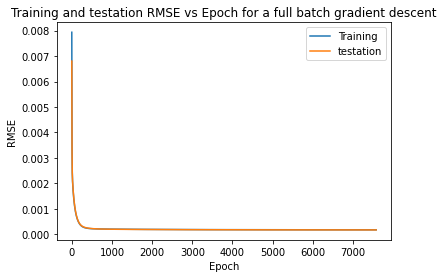

In [32]:
# Implement full-batch gradient descent
np.random.seed(2)
w_min = 0.001
w = w_min * (np.random.random(X_train_scaled_1f.shape[1])).reshape(1,-1)     # Inital weights
lr = 0.01                                                    
CT = RMSE_test_direct * 1.001                                               # Convergence threshold
rmse_test = 0.1 + CT                                                        # Intialize rmse_test above CT
rmse_array_train = []
rmse_array_test = []

start_time = time.time()                                                     # Records current time
while rmse_test > CT:
  yPred_train = np.dot(X_train_scaled_1f, w.T)
  rmse_train = rmse(yPred_train, y_train_array)
  rmse_array_train.append(rmse_train)
  gradient = (1/len(yPred_train) * np.dot(X_train_scaled_1f.T, yPred_train - y_train_array)).reshape(1,-1)
  w = w - lr * gradient                                                      # Weight update
  yPred_test = np.dot(X_test_scaled_1f, w.T)
  rmse_test = rmse(yPred_test, y_test_array)
  rmse_array_test.append(rmse_test)

print("--- Total Training Time: %s (s) ---" % (time.time() - start_time))
print(f'Converged testation RMSE: {rmse_array_test[-1]}')
print()
plt.plot(rmse_array_train, label='Training')
plt.plot(rmse_array_test, label='testation')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training and testation RMSE vs Epoch for a full batch gradient descent")
plt.legend()
plt.show()

The model is neither overfitted nor underfitted because at every epoch the RMSE for the training and validation set are very close